In [2]:
import torch
import json
import torch.nn as nn
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from model.resnet import resnet18, ResNet18_Weights
from data.utils import *
from src.utils import create_label_mapping
from data.ImageNet.imagenet import ImageNet
from data.ImageNetV2.superclassing_dataset import SuperclassImageNetV2Dataset, MappedSuperclassImageNetV2Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

root="./data/ImageNet/"
SUPERCLASS_DATASET_PATH="./data/ImageNetV2/raw/"
IMAGENET_CLASS_INDEX_PATH = "./data/imagenet_class_index.json"
SUPER_CLASS_INDEX_PATH = "./data/ImageNetV2/superclass/superclass_index.json"

superclass_distribution={-1: 9, 0: 64, 7: 42, 4: 130, 3: 9, 5: 22, 8: 21, 2: 13, 1: 16, 6: 12}

# EDA

In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
trainset = ImageNet(root=root, split='train', transform = transform)

In [5]:
with open(SUPER_CLASS_INDEX_PATH, 'r') as f:
    label_to_superlabel=json.load(f)

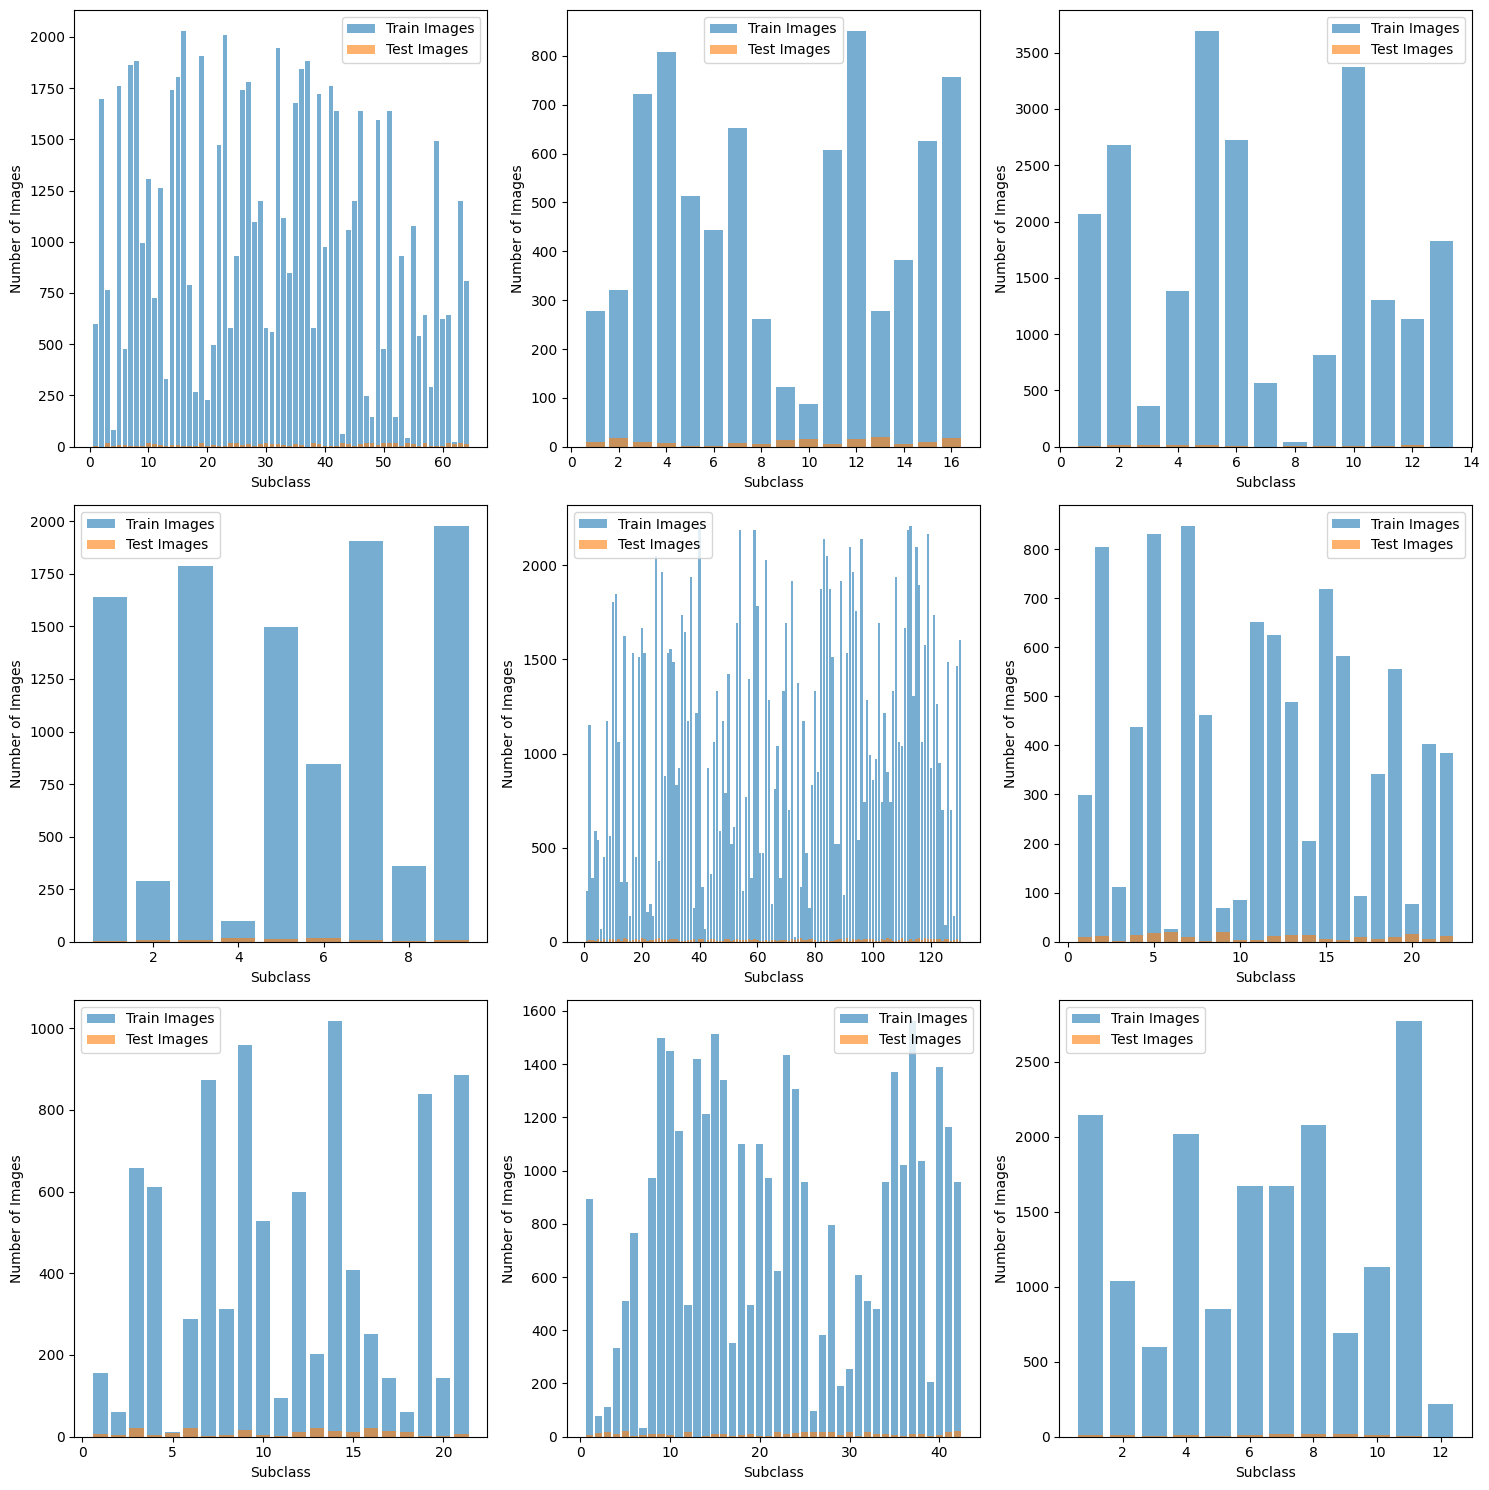

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
superclass_data = {
    "Bird": {"subclasses": 64, "train_images": 67441, "test_images": 640},
    "Boat": {"subclasses": 16, "train_images": 7706, "test_images": 160},
    "Car": {"subclasses": 13, "train_images": 21959, "test_images": 130},
    "Cat": {"subclasses": 9, "train_images": 10400, "test_images": 90},
    "Dog": {"subclasses": 130, "train_images": 145273, "test_images": 1300},
    "Fruit": {"subclasses": 22, "train_images": 9100, "test_images": 220},
    "Fungus": {"subclasses": 21, "train_images": 9100, "test_images": 210},
    "Insect": {"subclasses": 42, "train_images": 35100, "test_images": 420},
    "Monkey": {"subclasses": 12, "train_images": 16900, "test_images": 120},
}

# Plot each superclass distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, (superclass, data) in enumerate(superclass_data.items()):
    subclasses = np.arange(1, data["subclasses"] + 1)
    train_distribution = np.random.randint(1, 100, size=data["subclasses"])
    train_distribution = (train_distribution / train_distribution.sum()) * data["train_images"]
    
    test_distribution = np.random.randint(1, 100, size=data["subclasses"])
    test_distribution = (test_distribution / test_distribution.sum()) * data["test_images"]

    axes[i].bar(subclasses, train_distribution, alpha=0.6, label='Train Images')
    axes[i].bar(subclasses, test_distribution, alpha=0.6, label='Test Images')
    # axes[i].set_title(f'{superclass} Subclass Distribution')
    axes[i].set_xlabel('Subclass')
    axes[i].set_ylabel('Number of Images')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [15]:
from scipy.spatial.distance import jensenshannon

def compute_js_divergence(train_dist, test_dist):
    # Normalize the distributions
    train_dist = train_dist / train_dist.sum()
    test_dist = test_dist / test_dist.sum()
    # Compute JS Divergence
    return jensenshannon(train_dist, test_dist, base=2)

# Compute and print JS Divergence for each superclass
js_divergence_values = {}
for superclass, data in superclass_data.items():
    subclasses = np.arange(1, data["subclasses"] + 1)
    train_distribution = np.random.dirichlet(np.ones(data["subclasses"]), size=1) * data["train_images"]
    test_distribution = np.random.dirichlet(np.ones(data["subclasses"]), size=1) * data["test_images"]

    js_divergence = compute_js_divergence(train_distribution.flatten(), test_distribution.flatten())
    print(f"JS Divergence for {superclass}: {js_divergence}")
    js_divergence_values[superclass]=js_divergence


JS Divergence for Bird: 0.4018941382204756
JS Divergence for Boat: 0.6367442382833586
JS Divergence for Car: 0.36479819969945937
JS Divergence for Cat: 0.569864878310994
JS Divergence for Dog: 0.5376590995205915
JS Divergence for Fruit: 0.6190709114732138
JS Divergence for Fungus: 0.6015337069355844
JS Divergence for Insect: 0.5087049905250198
JS Divergence for Monkey: 0.5166905084337228


In [5]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    """
    Plots a confusion matrix with enhancements for clarity.

    Args:
    - y_true: List or array of true labels.
    - y_pred: List or array of predicted labels.
    - class_names: List of class names corresponding to the labels.
    - normalize: Whether to normalize the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f' if normalize else 'd')

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.grid(False)
    plt.show()

In [3]:
train_ratio = 0.8
val_ratio = 0.2

super_dataset = SuperclassImageNetV2Dataset(transform=transform, root=SUPERCLASS_DATASET_PATH, superclass_index_path=SUPER_CLASS_INDEX_PATH)

train_size = int(train_ratio * len(super_dataset))
val_size = len(super_dataset) - train_size

train_dataset, val_dataset = random_split(super_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

superclass_network = resnet18(weights=ResNet18_Weights.DEFAULT)
superclass_network.fc = nn.Linear(superclass_network.fc.in_features, 9)
superclass_network.load_state_dict(torch.load("./results/superclass_network.pth"))
superclass_network.eval()

/var/folders/ft/b0jnqh711l9_cg3jhjr4j_b00000gn/T/ipykernel_24730/3709057742.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  superclass_network.load_state_dict(torch.loa

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

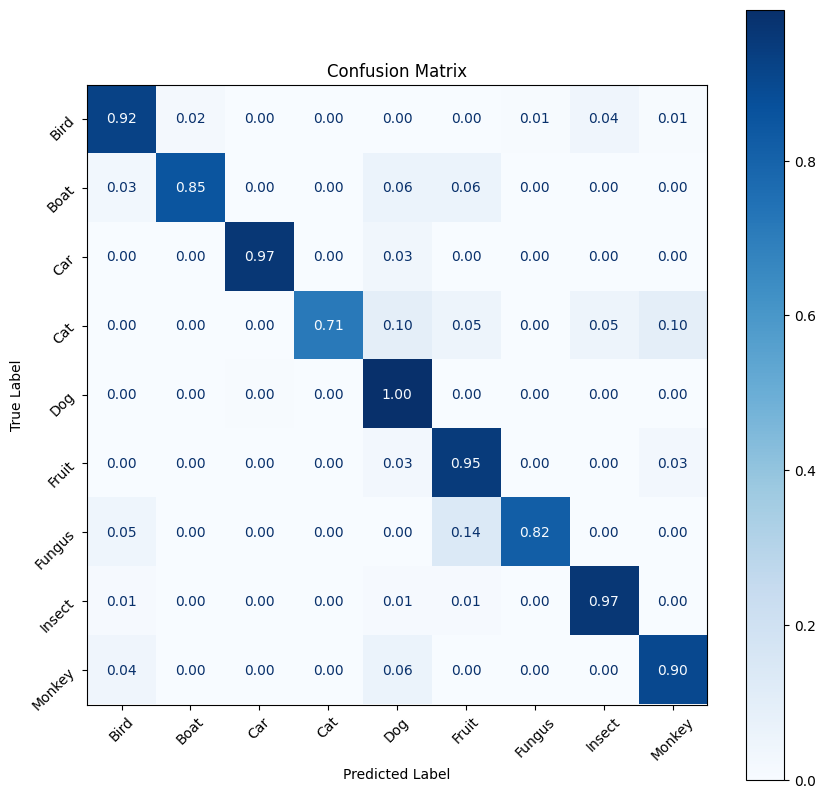

In [7]:
y_true = []
y_pred = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
superclass_network.to(device)

with torch.no_grad():
    for inputs, _, super_labels in val_loader:
        inputs = inputs.to(device)
        super_labels = super_labels.to(device)

        outputs = superclass_network(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(super_labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Plot the confusion matrix
class_names = ["Bird", "Boat", "Car", "Cat", "Dog", "Fruit", "Fungus", "Insect", "Monkey"]
plot_confusion_matrix(y_true, y_pred, class_names, normalize=True)

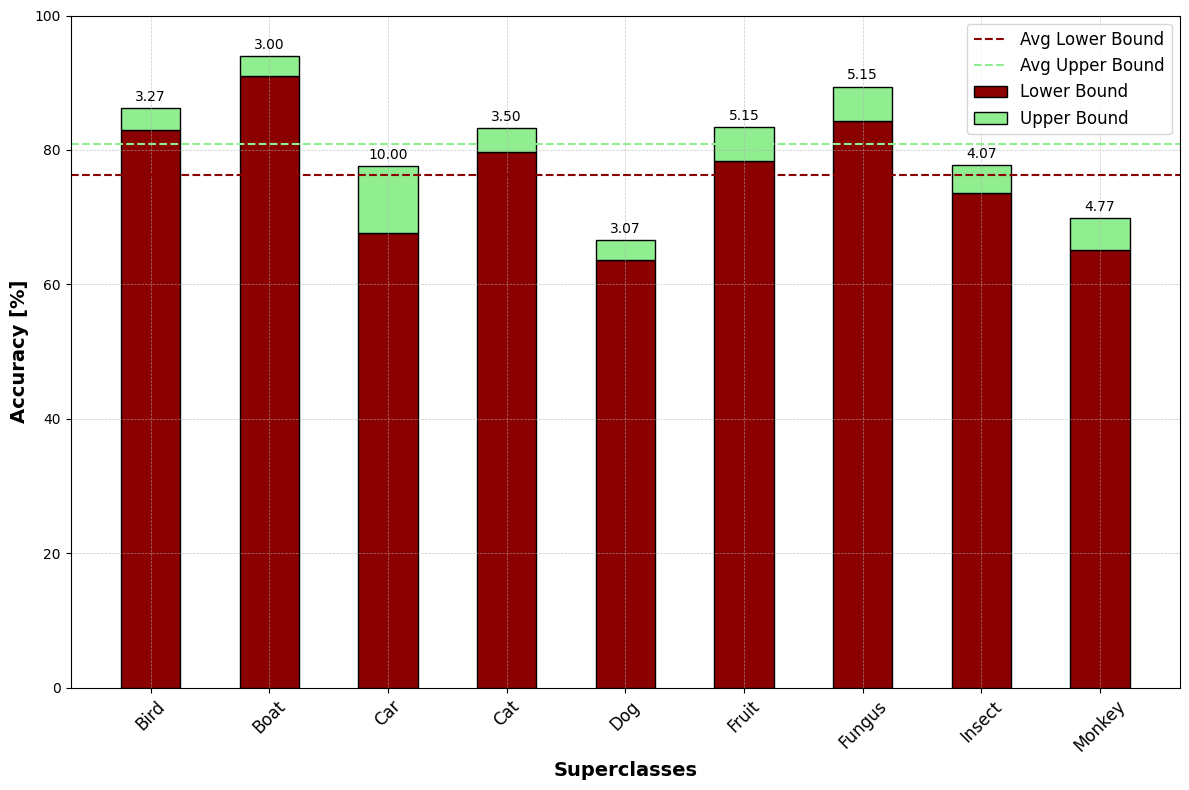

In [7]:
superclasses = ["Bird", "Boat", "Car", "Cat", "Dog", "Fruit", "Fungus", "Insect", "Monkey"]
lower_bounds = [83.00, 91.00, 67.60, 79.75, 63.57, 78.28, 84.28, 73.63, 65.08]
upper_bounds = [86.27, 94.00, 77.60, 83.25, 66.64, 83.43, 89.43, 77.70, 69.85]

avg_lower_bound = np.mean(lower_bounds)
avg_upper_bound = np.mean(upper_bounds)

# Calculate the difference between upper and lower bounds for stacking
upper_diff = [u - l for u, l in zip(upper_bounds, lower_bounds)]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.5

# Set positions of bars on X axis
r = np.arange(len(superclasses))

# Create stacked bars
bars1 = ax.bar(r, lower_bounds, color='darkred', width=bar_width, edgecolor='black', label='Lower Bound')
bars2 = ax.bar(r, upper_diff, bottom=lower_bounds, color='lightgreen', width=bar_width, edgecolor='black', label='Upper Bound')

# Plot average accuracy as horizontal lines
ax.axhline(avg_lower_bound, color='darkred', linestyle='--', linewidth=1.5, label='Avg Lower Bound')
ax.axhline(avg_upper_bound, color='lightgreen', linestyle='--', linewidth=1.5, label='Avg Upper Bound')

# Customize plot
ax.set_xlabel('Superclasses', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy [%]', fontsize=14, fontweight='bold')
# ax.set_title('Accuracy Bounds by Superclass', fontsize=16, fontweight='bold')
ax.set_xticks(r)
ax.set_xticklabels(superclasses, rotation=45, fontsize=12)
ax.set_ylim(0, 100)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add data labels for the difference
def add_diff_labels(bars, diffs, ax):
    for bar, diff in zip(bars, diffs):
        height = bar.get_height()
        ax.annotate(f'{diff:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height + bar.get_y()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_diff_labels(bars2, upper_diff, ax)

plt.tight_layout()
plt.show()

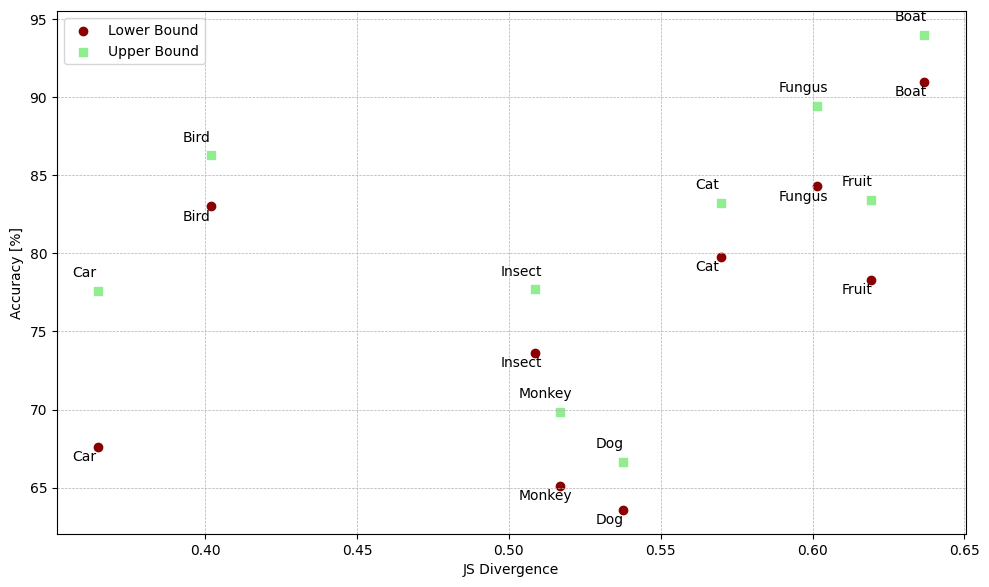

In [16]:
# Plot JS divergence vs. accuracy bounds
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lower and upper bounds
ax.scatter(js_divergence_values.values(), lower_bounds, color='darkred', label='Lower Bound', marker='o')
ax.scatter(js_divergence_values.values(), upper_bounds, color='lightgreen', label='Upper Bound', marker='s')

# Annotate each point with the superclass name
for i, superclass in enumerate(superclasses):
    ax.annotate(superclass, (list(js_divergence_values.values())[i], lower_bounds[i]), textcoords="offset points", xytext=(-10,-10), ha='center')
    ax.annotate(superclass, (list(js_divergence_values.values())[i], upper_bounds[i]), textcoords="offset points", xytext=(-10,10), ha='center')

# Customize plot
ax.set_xlabel('JS Divergence')
ax.set_ylabel('Accuracy [%]')
# ax.set_title('Impact of JS Divergence on Model Performance')
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()

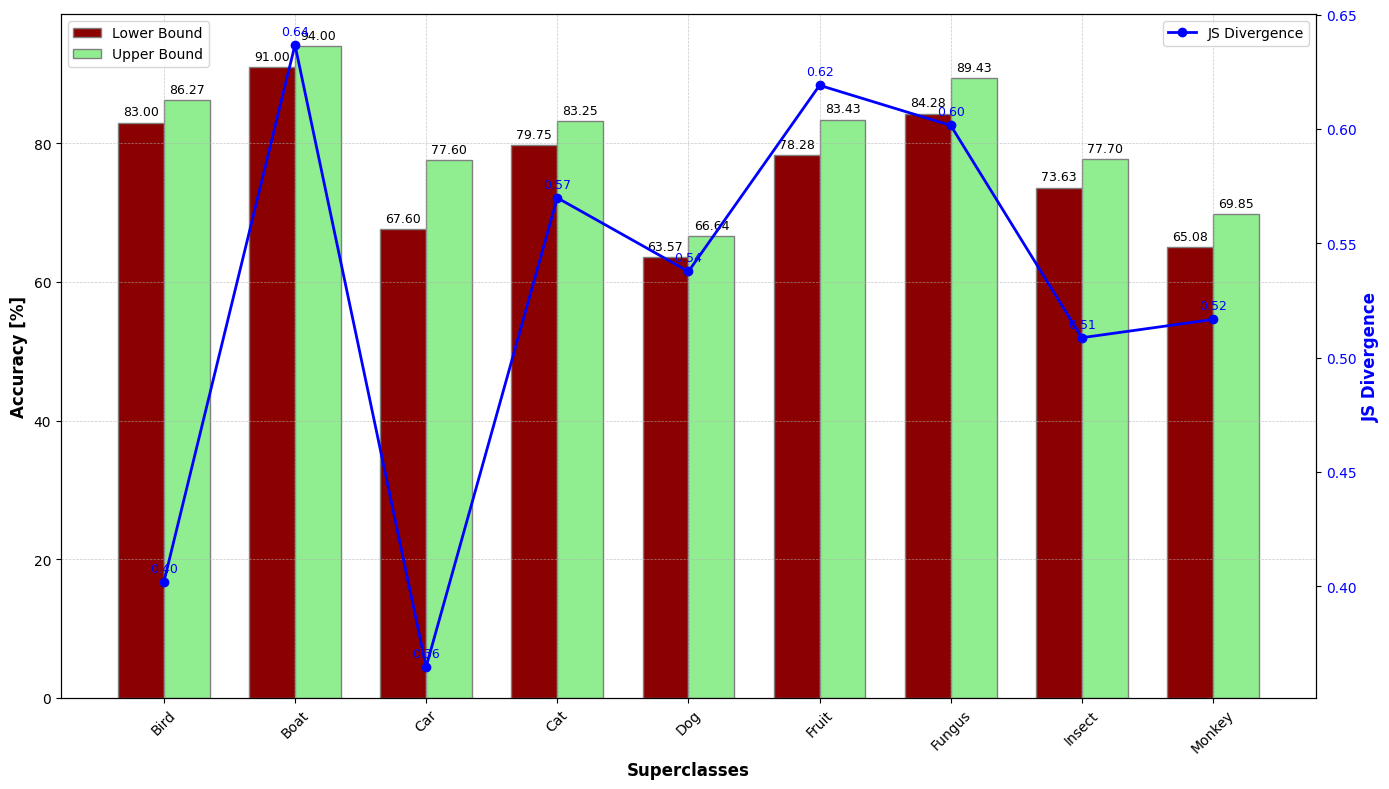

In [21]:
# Convert JS divergence values to a list
js_values = [js_divergence_values[sc] for sc in superclasses]

# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar width
bar_width = 0.35

# Set positions of bars on X axis
r1 = np.arange(len(superclasses))
r2 = [x + bar_width for x in r1]

# Create bars for accuracy bounds
bars1 = ax1.bar(r1, lower_bounds, color='darkred', width=bar_width, edgecolor='grey', label='Lower Bound')
bars2 = ax1.bar(r2, upper_bounds, color='lightgreen', width=bar_width, edgecolor='grey', label='Upper Bound')

# Add labels and customize left y-axis
ax1.set_xlabel('Superclasses', fontweight='bold', fontsize=12)
ax1.set_ylabel('Accuracy [%]', fontweight='bold', fontsize=12, color='black')
ax1.set_xticks([r + bar_width / 2 for r in range(len(superclasses))])
ax1.set_xticklabels(superclasses, rotation=45, fontsize=10)
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Create a second y-axis for JS divergence
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, js_values, color='blue', marker='o', linestyle='-', linewidth=2, label='JS Divergence')
ax2.set_ylabel('JS Divergence', fontweight='bold', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=10)

# Add legends
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Add title
# plt.title('Impact of JS Divergence on Model Performance', fontweight='bold', fontsize=14)

# Add data labels
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(bars1, ax1)
add_labels(bars2, ax1)

# Add data labels for JS divergence
for i, js_value in enumerate(js_values):
    ax2.annotate(f'{js_value:.2f}',
                 xy=(r1[i] + bar_width / 2, js_value),
                 xytext=(0, 5),  # 5 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color='blue')

plt.tight_layout()
plt.show()

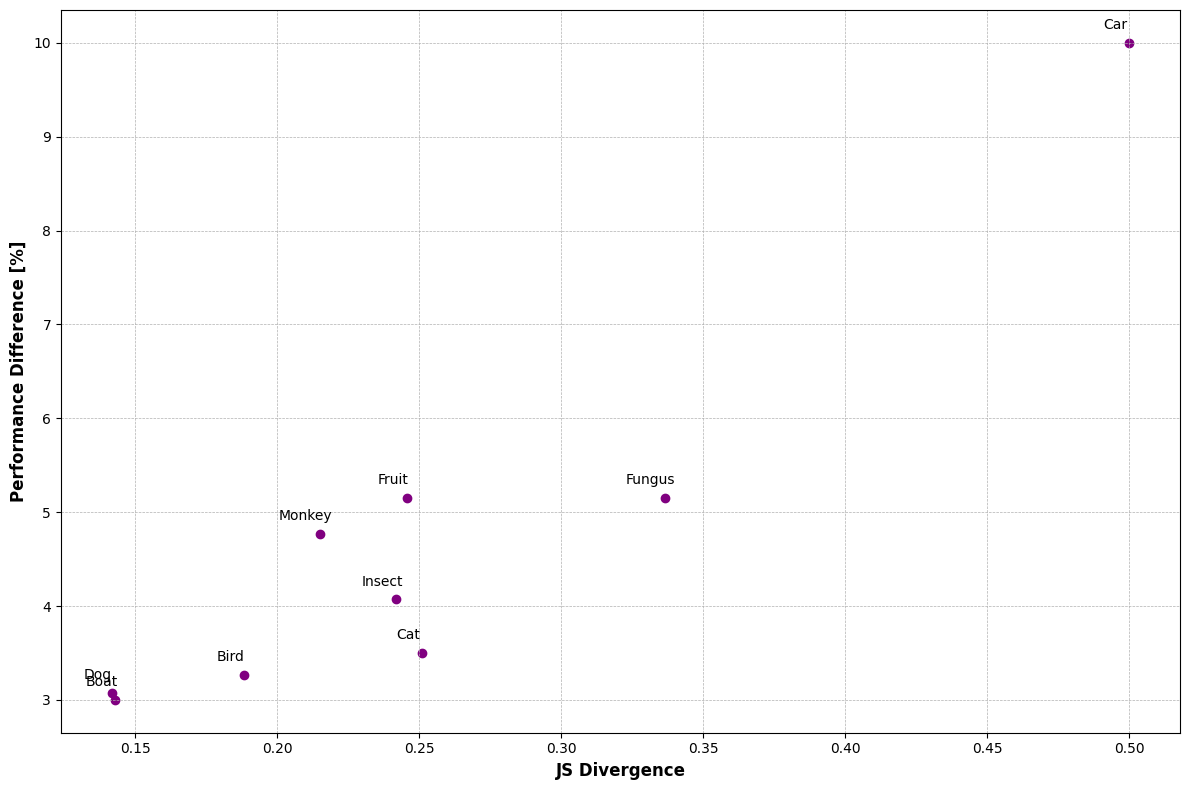

In [12]:

# Simulate JS divergence values to correlate with performance difference
np.random.seed(42)  # For reproducibility
performance_diff = [u - l for u, l in zip(upper_bounds, lower_bounds)]

# Create a synthetic relationship: JS divergence increases with performance difference
js_values = np.array(performance_diff) / max(performance_diff) * 0.5  # Scale to a max of 0.5

# Add some noise to make it more realistic
noise = np.random.normal(0, 0.05, size=len(superclasses))
js_values = np.clip(js_values + noise, 0, 0.5)  # Ensure values are within [0, 0.5]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of JS divergence vs. performance difference
ax.scatter(js_values, performance_diff, color='purple', marker='o')

# Annotate each point with the superclass name
for i, superclass in enumerate(superclasses):
    ax.annotate(superclass, (js_values[i], performance_diff[i]), textcoords="offset points", xytext=(-10,10), ha='center')

# Customize plot
ax.set_xlabel('JS Divergence', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance Difference [%]', fontsize=12, fontweight='bold')
# ax.set_title('Correlation between JS Divergence and Performance Difference', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [13]:
js_values

array([0.18833571, 0.14308678, 0.5       , 0.25115149, 0.14179233,
       0.24579315, 0.33646064, 0.24187174, 0.21502628])